In [20]:
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import random

# importing sklearn libraries
from sklearn import neural_network, linear_model, preprocessing, svm, tree
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB

# importing keras libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

import warnings

# supressing the warning on the usage of Linear Regression model
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [21]:
forest_fires = pd.read_csv('forestfires.csv')
forest_fires

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29
514,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16
515,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00


# Converting the labels under month and day to integers

In [22]:
forest_fires.month.replace(('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'),(1,2,3,4,5,6,7,8,9,10,11,12), inplace=True)
forest_fires.day.replace(('mon','tue','wed','thu','fri','sat','sun'),(1,2,3,4,5,6,7), inplace=True)

In [23]:
forest_fires.describe()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,7.475822,4.259188,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,2.275990,2.072929,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,1.000000,1.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,7.000000,2.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,8.000000,5.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,9.000000,6.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,12.000000,7.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


# Corelation analysis

In [24]:
forest_fires.corr()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
X,1.000000,0.539548,-0.065003,-0.024922,-0.021039,-0.048384,-0.085916,0.006210,-0.051258,0.085223,0.018798,0.065387,0.063385
Y,0.539548,1.000000,-0.066292,-0.005453,-0.046308,0.007782,-0.101178,-0.024488,-0.024103,0.062221,-0.020341,0.033234,0.044873
month,-0.065003,-0.066292,1.000000,-0.050837,0.291477,0.466645,0.868698,0.186597,0.368842,-0.095280,-0.086368,0.013438,0.056496
day,-0.024922,-0.005453,-0.050837,1.000000,-0.041068,0.062870,0.000105,0.032909,0.052190,0.092151,0.032478,-0.048340,0.023226
FFMC,-0.021039,-0.046308,0.291477,-0.041068,1.000000,0.382619,0.330512,0.531805,0.431532,-0.300995,-0.028485,0.056702,0.040122
DMC,-0.048384,0.007782,0.466645,0.062870,0.382619,1.000000,0.682192,0.305128,0.469594,0.073795,-0.105342,0.074790,0.072994
DC,-0.085916,-0.101178,0.868698,0.000105,0.330512,0.682192,1.000000,0.229154,0.496208,-0.039192,-0.203466,0.035861,0.049383
ISI,0.006210,-0.024488,0.186597,0.032909,0.531805,0.305128,0.229154,1.000000,0.394287,-0.132517,0.106826,0.067668,0.008258
temp,-0.051258,-0.024103,0.368842,0.052190,0.431532,0.469594,0.496208,0.394287,1.000000,-0.527390,-0.227116,0.069491,0.097844
RH,0.085223,0.062221,-0.095280,0.092151,-0.300995,0.073795,-0.039192,-0.132517,-0.527390,1.000000,0.069410,0.099751,-0.075519


# Extracting features

In [25]:
x_values = list(forest_fires['X'])
y_values = list(forest_fires['Y'])

loc_values = []

for index in range(0, len(x_values)):
    temp_value = []

    temp_value.append(x_values[index])
    temp_value.append(y_values[index])
    loc_values.append(temp_value)

In [26]:
month_values = list(forest_fires['month'])
day_values = list(forest_fires['day'])

ffmc_values = list(forest_fires['FFMC'])
dmc_values = list(forest_fires['DMC'])
dc_values = list(forest_fires['DC'])
isi_values = list(forest_fires['ISI'])

temp_values = list(forest_fires['temp'])
rh_values = list(forest_fires['RH'])
wind_values = list(forest_fires['wind'])
rain_values = list(forest_fires['rain'])

area_values = list(forest_fires['area'])

# Histogram plot for burned area

In [30]:
def histogram_plot(dataset, title):
    plt.figure(figsize=(8, 6))    
    
    ax = plt.subplot()    
    ax.spines["top"].set_visible(False)    
    ax.spines["bottom"].set_visible(False)    
    ax.spines["right"].set_visible(False)    
    ax.spines["left"].set_visible(False)
    
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left() 
    
    plt.title(title, fontsize = 22)
    plt.hist(dataset, edgecolor='black', linewidth=1.2)


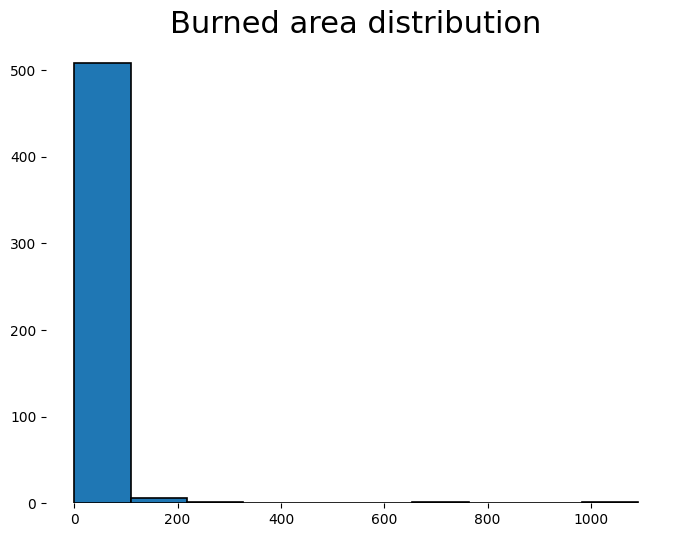

In [31]:
histogram_plot(area_values, title = "Burned area distribution")
plt.show()

In [32]:
attribute_list = []

for index in range(0, len(x_values)):
    temp_list = []
    
    temp_list.append(x_values[index])
    temp_list.append(y_values[index])
    
    temp_list.append(month_values[index])
    temp_list.append(day_values[index])

    temp_list.append(ffmc_values[index])
    temp_list.append(dmc_values[index])
    temp_list.append(dc_values[index])
    temp_list.append(isi_values[index])

    temp_list.append(temp_values[index])
    temp_list.append(rh_values[index])
    temp_list.append(wind_values[index])
    temp_list.append(rain_values[index])
    
    attribute_list.append(temp_list)

# Percentage of dataset with burned area > 0

In [33]:
total_count = 0
positive_data_count = 0

for value in area_values:
    if(value > 0):
        positive_data_count = positive_data_count + 1
    total_count = total_count + 1

print("The number of data records with 'burned area' > 0 are " + str(positive_data_count) + " and the total number of records are " + str(total_count) + ".")
print("The percentage value is " + str(positive_data_count/total_count * 100) + ".")

The number of data records with 'burned area' > 0 are 270 and the total number of records are 517.
The percentage value is 52.22437137330754.


# Applying log transformation to the burned area variable

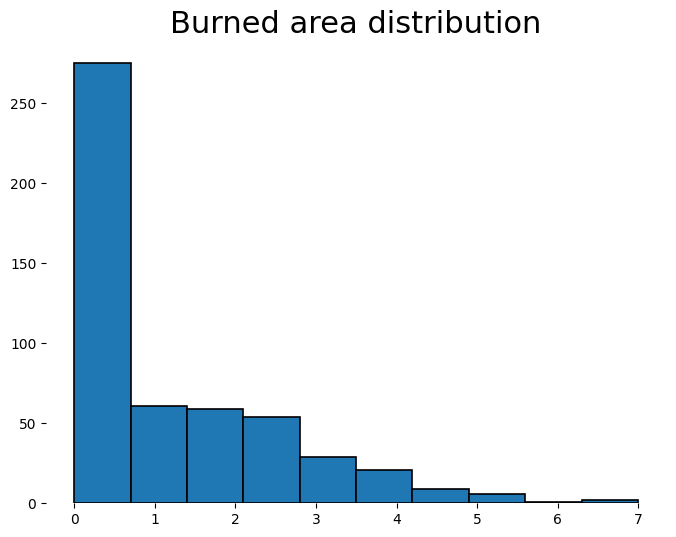

In [34]:
area_values = list(np.log(np.array(area_values) + 1))
histogram_plot(area_values, title = "Burned area distribution")
# area_values

# Now we have processed data

# Normalisation of all data

In [37]:
n_x_values = preprocessing.normalize([x_values])[0]
n_y_values = preprocessing.normalize([y_values])[0]

n_month_values = preprocessing.normalize([month_values])[0]
n_day_values = preprocessing.normalize([day_values])[0]

n_ffmc_values = preprocessing.normalize([ffmc_values])[0]
n_dmc_values = preprocessing.normalize([dmc_values])[0]
n_dc_values = preprocessing.normalize([dc_values])[0]
n_isi_values = preprocessing.normalize([isi_values])[0]

n_temp_values = preprocessing.normalize([temp_values])[0]
n_rh_values = preprocessing.normalize([rh_values])[0]
n_wind_values = preprocessing.normalize([wind_values])[0]
n_rain_values = preprocessing.normalize([rain_values])[0]

n_area_values = preprocessing.normalize([area_values])[0]
n_attribute_list = []

for index in range(0, len(n_x_values)):
    temp_list = []
    
    temp_list.append(n_x_values[index])
    temp_list.append(n_y_values[index])
    
    temp_list.append(n_month_values[index])
    temp_list.append(n_day_values[index])

    temp_list.append(n_ffmc_values[index])
    temp_list.append(n_dmc_values[index])
    temp_list.append(n_dc_values[index])
    temp_list.append(n_isi_values[index])

    temp_list.append(n_temp_values[index])
    temp_list.append(n_rh_values[index])
    temp_list.append(n_wind_values[index])
    temp_list.append(n_rain_values[index])
    
    n_attribute_list.append(temp_list)

# Applying models on normalised data

In [38]:
mse_values = []
variance_score = []
train_x, test_x, train_y, test_y = train_test_split(n_attribute_list, n_area_values, test_size=0.3, random_state = 9)

# Linear Regression

In [41]:
linear_regression = linear_model.LinearRegression()

linear_regression.fit(train_x, train_y)
predicted_y = linear_regression.predict(test_x)

# print('Coefficients: \n', linear_regression.coef_)

print("\nMean squared error: ", mean_squared_error(test_y, predicted_y))
print('Variance score: %.2f' % r2_score(test_y, predicted_y))

mse_values.append(mean_squared_error(test_y, predicted_y))
variance_score.append(r2_score(test_y, predicted_y))



Mean squared error:  0.0014262234988405913
Variance score: 0.00


# Decision Tree

In [43]:
decision_tree = tree.DecisionTreeRegressor()

decision_tree.fit(train_x, train_y)
predicted_y = decision_tree.predict(test_x)

print("Mean squared error: ", mean_squared_error(test_y, predicted_y))
print('Variance score: %.2f' % r2_score(test_y, predicted_y))

mse_values.append(mean_squared_error(test_y, predicted_y))
variance_score.append(r2_score(test_y, predicted_y))

Mean squared error:  0.00259748451984878
Variance score: -0.82


# MLP

In [44]:
mlp = neural_network.MLPRegressor(hidden_layer_sizes = (150,50,50), activation = "tanh", solver = "sgd", learning_rate = "adaptive")

mlp.fit(train_x, train_y)
predicted_y = mlp.predict(test_x)

print("Mean squared error: ", mean_squared_error(test_y, predicted_y))
print('Variance score: %.2f' % r2_score(test_y, predicted_y))

mse_values.append(mean_squared_error(test_y, predicted_y))
variance_score.append(r2_score(test_y, predicted_y))


Mean squared error:  0.0016409843684578357
Variance score: -0.15


# SVM

In [45]:
svm_model = svm.SVR()

svm_model.fit(train_x, train_y)
predicted_y = svm_model.predict(test_x)

print("Mean squared error: ", mean_squared_error(test_y, predicted_y))
print('Variance score: %.2f' % r2_score(test_y, predicted_y))

mse_values.append(mean_squared_error(test_y, predicted_y))
variance_score.append(r2_score(test_y, predicted_y))

Mean squared error:  0.004579753060572858
Variance score: -2.20


# Random Forest

In [46]:
random_forest = RandomForestRegressor()
random_forest.fit(train_x, train_y)
predicted_y = random_forest.predict(test_x)

print("Mean squared error: ", mean_squared_error(test_y, predicted_y))
print('Variance score: %.2f' % r2_score(test_y, predicted_y))

mse_values.append(mean_squared_error(test_y, predicted_y))
variance_score.append(r2_score(test_y, predicted_y))

Mean squared error:  0.0016931695296334654
Variance score: -0.18


# Bayesian Ridge

In [47]:
bayesian_ridge = linear_model.BayesianRidge()
bayesian_ridge.fit(train_x, train_y)
predicted_y = bayesian_ridge.predict(test_x)

print("Mean squared error: ", mean_squared_error(test_y, predicted_y))
print('Variance score: %.2f' % r2_score(test_y, predicted_y))

mse_values.append(mean_squared_error(test_y, predicted_y))
variance_score.append(r2_score(test_y, predicted_y))


Mean squared error:  0.0014433272248326264
Variance score: -0.01


# Lasso

In [48]:
lasso_model = linear_model.Lasso()
lasso_model.fit(train_x, train_y)
predicted_y = lasso_model.predict(test_x)

print("Mean squared error: ", mean_squared_error(test_y, predicted_y))
print('Variance score: %.2f' % r2_score(test_y, predicted_y))

mse_values.append(mean_squared_error(test_y, predicted_y))
variance_score.append(r2_score(test_y, predicted_y))

Mean squared error:  0.0014437638154593492
Variance score: -0.01


# ANN

In [52]:
binary_area_values = []
count = 0

for value in area_values:
    if(value == 0):
        binary_area_values.append(0)
    else:
        binary_area_values.append(1)

In [53]:
train_x, test_x, train_y, test_y = train_test_split(attribute_list, binary_area_values, test_size=0.15, random_state = 4)

In [54]:
train_x_a = np.array(train_x)
test_x_a = np.array(test_x)
test_y_a = np.array(test_y)
train_y_temp = np.array(train_y)

train_y_cl = []
for i in range(len(train_y)):
    if(train_y[i]>0):
        train_y_cl.append(1)
    else:
        train_y_cl.append(0)
train_y_cl = np.array(train_y_cl)

print("Length of Training data is : "+str(len(train_x_a))+" and Test data is : " + str(len(test_x_a)))

Length of Training data is : 439 and Test data is : 78


In [55]:
model = Sequential()
model.add(Dense(12, activation='tanh',input_shape=(12,)))
model.add(Dense(12, activation='tanh',input_shape=(12,)))
model.add(Dense(1, activation='sigmoid'))

In [56]:
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
model.fit(train_x_a,train_y_cl, epochs=100, batch_size=10)

# Evaluate the model
scores = model.evaluate(test_x_a, test_y_a)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Epoch 1/100
44/44 [==============================] - 1s 3ms/step - loss: 0.6882 - accuracy: 0.5535
Epoch 2/100
44/44 [==============================] - 0s 2ms/step - loss: 0.6849 - accuracy: 0.5695
Epoch 3/100
44/44 [==============================] - 0s 2ms/step - loss: 0.6835 - accuracy: 0.5695
Epoch 4/100
44/44 [==============================] - 0s 3ms/step - loss: 0.6829 - accuracy: 0.5672
Epoch 5/100
44/44 [==============================] - 0s 2ms/step - loss: 0.6838 - accuracy: 0.5695
Epoch 6/100
44/44 [==============================] - 0s 3ms/step - loss: 0.6828 - accuracy: 0.5718
Epoch 7/100
44/44 [==============================] - 0s 3ms/step - loss: 0.6795 - accuracy: 0.5718
Epoch 8/100
44/44 [==============================] - 0s 2ms/step - loss: 0.6808 - accuracy: 0.5695
Epoch 9/100
44/44 [==============================] - 0s 3ms/step - loss: 0.6821 - accuracy: 0.5718
Epoch 10/100
44/44 [==============================] - 0s 4ms/step - loss: 0.6783 - accuracy: 0.5695
Epoch 11/

44/44 [==============================] - 0s 3ms/step - loss: 0.6669 - accuracy: 0.5900
Epoch 84/100
44/44 [==============================] - 0s 3ms/step - loss: 0.6702 - accuracy: 0.5877
Epoch 85/100
44/44 [==============================] - 0s 2ms/step - loss: 0.6675 - accuracy: 0.5945
Epoch 86/100
44/44 [==============================] - 0s 2ms/step - loss: 0.6719 - accuracy: 0.5854
Epoch 87/100
44/44 [==============================] - 0s 2ms/step - loss: 0.6747 - accuracy: 0.5831
Epoch 88/100
44/44 [==============================] - 0s 3ms/step - loss: 0.6726 - accuracy: 0.5809
Epoch 89/100
44/44 [==============================] - 0s 3ms/step - loss: 0.6723 - accuracy: 0.5831
Epoch 90/100
44/44 [==============================] - 0s 3ms/step - loss: 0.6710 - accuracy: 0.5831
Epoch 91/100
44/44 [==============================] - 0s 2ms/step - loss: 0.6674 - accuracy: 0.5900
Epoch 92/100
44/44 [==============================] - 0s 2ms/step - loss: 0.6669 - accuracy: 0.5991
Epoch 93/100


# ANN Regression Model

# Defining base model

In [57]:
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(12, input_dim=12, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [58]:
model = Sequential()
model.add(Dense(12, input_dim=12, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))

In [59]:
# compile model
model.compile(loss='mean_squared_error', optimizer='adam')

# train model
history = model.fit(np.array(train_x), np.array(train_y), epochs=150, batch_size=5, verbose=1)

Epoch 1/150
88/88 [==============================] - 1s 2ms/step - loss: 0.5408
Epoch 2/150
88/88 [==============================] - 0s 2ms/step - loss: 0.2845
Epoch 3/150
88/88 [==============================] - 0s 3ms/step - loss: 0.2818
Epoch 4/150
88/88 [==============================] - 0s 2ms/step - loss: 0.2718
Epoch 5/150
88/88 [==============================] - 0s 2ms/step - loss: 0.2720
Epoch 6/150
88/88 [==============================] - 0s 2ms/step - loss: 0.2940
Epoch 7/150
88/88 [==============================] - 0s 2ms/step - loss: 0.2897
Epoch 8/150
88/88 [==============================] - 0s 2ms/step - loss: 0.2811
Epoch 9/150
88/88 [==============================] - 0s 2ms/step - loss: 0.2622
Epoch 10/150
88/88 [==============================] - 0s 2ms/step - loss: 0.2733
Epoch 11/150
88/88 [==============================] - 0s 2ms/step - loss: 0.2669
Epoch 12/150
88/88 [==============================] - 0s 2ms/step - loss: 0.2548
Epoch 13/150
88/88 [=================

88/88 [==============================] - 0s 2ms/step - loss: 0.2431
Epoch 103/150
88/88 [==============================] - 0s 2ms/step - loss: 0.2426
Epoch 104/150
88/88 [==============================] - 0s 2ms/step - loss: 0.2401
Epoch 105/150
88/88 [==============================] - 0s 2ms/step - loss: 0.2399
Epoch 106/150
88/88 [==============================] - 0s 2ms/step - loss: 0.2402
Epoch 107/150
88/88 [==============================] - 0s 2ms/step - loss: 0.2392
Epoch 108/150
88/88 [==============================] - 0s 2ms/step - loss: 0.2419
Epoch 109/150
88/88 [==============================] - 0s 2ms/step - loss: 0.2418
Epoch 110/150
88/88 [==============================] - 0s 2ms/step - loss: 0.2411
Epoch 111/150
88/88 [==============================] - 0s 2ms/step - loss: 0.2381
Epoch 112/150
88/88 [==============================] - 0s 2ms/step - loss: 0.2371
Epoch 113/150
88/88 [==============================] - 0s 2ms/step - loss: 0.2381
Epoch 114/150
88/88 [=========

# Make Predictions

In [60]:
predicted = model.predict( np.array(test_x),batch_size=None, verbose=0, steps=1)

In [61]:
estimator = KerasRegressor(build_fn=baseline_model, nb_epoch=100, batch_size=5, verbose=1)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15048\843437586.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator = KerasRegressor(build_fn=baseline_model, nb_epoch=100, batch_size=5, verbose=1)


In [62]:
seed = 12
np.random.seed(seed)

# 10 fold validation

In [67]:
kfold = KFold(n_splits=10, random_state= seed, shuffle = True)
results = cross_val_score(estimator, np.array(test_x), np.array(test_y), cv=kfold)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

2/2 [==============================] - 0s 5ms/step - loss: 0.4661
Results: -10.00 (27.43) MSE


# Checking MSE & Variance score

In [68]:
print("Mean squared error: ", mean_squared_error(test_y, predicted))
print('Variance score: %.2f' % r2_score(test_y, predicted))


Mean squared error:  0.23703635305569284
Variance score: 0.05
